## ANN Example with BCELoss function -> For Binary classification

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim 
from torch.autograd import Variable

In [2]:
device = torch.device("cpu")

In [5]:
# Let's import the dataset first
df = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Git Repositories\PyTorch_Projects\Churn_Modelling.csv')

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
X = df.iloc[:,3:13].values
y = df.iloc[:,13].values


In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = (ct.fit_transform(X))
X.shape


(10000, 12)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(pd.DataFrame(X_train))

            0         1         2         3         4         5         6   \
0     1.001501 -0.579467 -0.576388  0.356500  0.913248 -0.655786  0.345680   
1    -0.998501  1.725723 -0.576388 -0.203898  0.913248  0.294938 -0.348369   
2    -0.998501 -0.579467  1.734942 -0.961472  0.913248 -1.416365 -0.695393   
3     1.001501 -0.579467 -0.576388 -0.940717 -1.094993 -1.131148  1.386753   
4     1.001501 -0.579467 -0.576388 -1.397337  0.913248  1.625953  1.386753   
...        ...       ...       ...       ...       ...       ...       ...   
7995  1.001501 -0.579467 -0.576388  1.207474  0.913248  1.435808  1.039728   
7996  1.001501 -0.579467 -0.576388  0.314989 -1.094993  1.816097 -1.389442   
7997  1.001501 -0.579467 -0.576388  0.865009 -1.094993 -0.085351 -1.389442   
7998  1.001501 -0.579467 -0.576388  0.159323  0.913248  0.390011  1.039728   
7999 -0.998501  1.725723 -0.576388  0.470655  0.913248  1.150590 -1.389442   

            7         8         9         10        11  
0    -

In [26]:
X_test.shape

(2000, 12)

In [27]:
class ANN(nn.Module):
    
    def __init__(self, input_dimension, output_dimension):
        super(ANN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dimension, 64),
            nn.Sigmoid(),            
            nn.Linear(64,64),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.Sigmoid(),
            nn.Linear(32,32),
            nn.Sigmoid(),
            nn.Linear(32,output_dimension),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
        
        

The output neuron would be 1 

In [33]:
model = ANN(12,1).to(device)
print(model)

ANN(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


See the optimizer is <strong>Adam</strong>

In [34]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


In [35]:
# Converting to tensors for nupmy Array
X_train=torch.FloatTensor(X_train).to(device)
X_test=torch.FloatTensor(X_test).to(device)
y_train=torch.LongTensor(y_train).to(device)
y_test=torch.LongTensor(y_test).to(device)

# Make torch datasets from train and test sets
train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 64, shuffle = True)

This is how the predictions are calculated

<strong>preds = torch.round(output).to(int).squeeze(1)</strong>

In [36]:
epochs = 100

running_loss_history = []
epoch_list = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

print("Starting with the training...")

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in train_loader:

        inputs = Variable(inputs).to(device)
        labels = Variable(labels).to(device)

        output = model(inputs)
        
        loss = criterion(output, labels.unsqueeze(1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.round(output).to(int).squeeze(1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_inputs = Variable(val_inputs).to(device)
                val_labels = Variable(val_labels).to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels.unsqueeze(1).float())
                
                val_preds = torch.round(val_outputs).to(int).squeeze(1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = running_corrects.float()/ len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(test_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(test_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

    epoch_list.append(e + 1)
    
    

Starting with the training...
epoch : 1
training loss: 0.0075, acc 0.7945 
validation loss: 0.0068, validation acc 0.8035 
epoch : 2
training loss: 0.0069, acc 0.7920 
validation loss: 0.0066, validation acc 0.8010 
epoch : 3
training loss: 0.0068, acc 0.7928 
validation loss: 0.0067, validation acc 0.8005 
epoch : 4
training loss: 0.0067, acc 0.8096 
validation loss: 0.0066, validation acc 0.8250 
epoch : 5
training loss: 0.0065, acc 0.8285 
validation loss: 0.0065, validation acc 0.8290 
epoch : 6
training loss: 0.0064, acc 0.8289 
validation loss: 0.0063, validation acc 0.8385 
epoch : 7
training loss: 0.0064, acc 0.8326 
validation loss: 0.0063, validation acc 0.8345 
epoch : 8
training loss: 0.0063, acc 0.8345 
validation loss: 0.0064, validation acc 0.8400 
epoch : 9
training loss: 0.0063, acc 0.8351 
validation loss: 0.0062, validation acc 0.8370 
epoch : 10
training loss: 0.0060, acc 0.8415 
validation loss: 0.0060, validation acc 0.8485 
epoch : 11
training loss: 0.0058, acc 0

epoch : 88
training loss: 0.0041, acc 0.8923 
validation loss: 0.0063, validation acc 0.8520 
epoch : 89
training loss: 0.0041, acc 0.8960 
validation loss: 0.0069, validation acc 0.8445 
epoch : 90
training loss: 0.0041, acc 0.8907 
validation loss: 0.0062, validation acc 0.8505 
epoch : 91
training loss: 0.0041, acc 0.8917 
validation loss: 0.0064, validation acc 0.8515 
epoch : 92
training loss: 0.0041, acc 0.8916 
validation loss: 0.0064, validation acc 0.8470 
epoch : 93
training loss: 0.0040, acc 0.8925 
validation loss: 0.0063, validation acc 0.8525 
epoch : 94
training loss: 0.0040, acc 0.8915 
validation loss: 0.0064, validation acc 0.8500 
epoch : 95
training loss: 0.0040, acc 0.8946 
validation loss: 0.0064, validation acc 0.8515 
epoch : 96
training loss: 0.0040, acc 0.8961 
validation loss: 0.0066, validation acc 0.8455 
epoch : 97
training loss: 0.0040, acc 0.8959 
validation loss: 0.0064, validation acc 0.8555 
epoch : 98
training loss: 0.0039, acc 0.8967 
validation los

KeyboardInterrupt: 

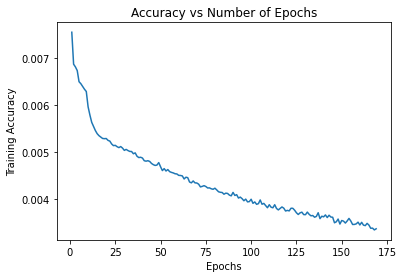

In [37]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.show()

Text(69.0, 0.5, 'Predicted Values')

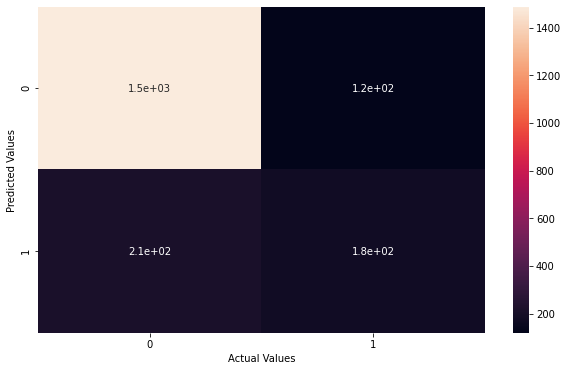

In [39]:
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred=model(data)
        y_pred_new = 0 if y_pred <= 0.5 else 1
        predictions.append(y_pred_new)
        
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.to('cpu'),predictions)
cm

plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [40]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test.to('cpu'),predictions)
score

0.8345